<h4 align='right'> $\textit{Aurélien Castre, Eliott Tourtois}$ </h4>
<h1 align='center'> $\textbf{Filtrage - MACS207b}$ </h1>
$\newline$

# Ce qu'il reste à faire :

- approximation de tau
- on pourrait ajuster le nombre de points pour l'approx de l'ODE en fct de T[i+1]-T[i]
- tweak kmeans
- comparer les deux méthodes

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.integrate import odeint
from sklearn.cluster import KMeans

$\textbf{Question 1}$

$\tau$ suit une loi exponentielle de paramètre $\mu$, on peut donc facilement calculer $h$ :

$$ h(s)=\frac{f(s)}{1-F(s)}= \left\{
    \begin{array}{ll}
        \frac{\mu\exp(-\mu s)}{\exp(-\mu s)} & \mbox{si } s \in \mathbb{R}_+ \\
        0 & \mbox{sinon.}
    \end{array}
\right. = \mu \mathbb{1}_{\mathbb{R}_+}(s) $$

$\textbf{Question 2}$

Pour simuler $N$ sur l'intervalle de temps $[0, T]$, on commence par tirer $\tau$ selon une loi exponentielle de paramètre $\mu$. Ensuite, on tire les instants de saut de $N_a$ selon une loi exponentielle de paramètre $a$ en partant de 0 et tant qu'on ne dépasse pas la valeur de $\tau(\omega)$. Enfin, on tire les instants de saut de $N_b$ selon une loi exponentielle de paramètre $b$ en partant de $\tau(\omega)$ et tant qu'on ne dépasse pas $T$.

In [5]:
def N(mu, a, b, end, rng = np.random.default_rng(None)) :
    """Simulate the trajectory of N between 0 and T

    Parameters
    ----------
    mu : float
        The parameter of the exponential distribution of tau
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    end : float
        The end of the simulation
    rng : Generator, optional
        A Random Number Generator for reproducibility
        (default is np.random.default_rng(None))

    Returns
    -------
    float
        The value of tau in the simulation
    list
        The list of arrival times of the Poisson process before tau
    list
        The list of arrival times of the Poisson process after tau
        (empty if tau > T)
    """
    
    # Simulate tau using inverse transform sampling
    u = rng.uniform()
    tau = -1/mu*np.log(u)
    
    # Simulate the first Poisson process
    Tas = []
    t = 0
    while t <= min(tau, end) :
        u = rng.uniform()
        t += -1/a*np.log(u)
        Tas.append(t)
    Tas.pop()
    
    # Simulate the second Poisson process
    Tbs = []
    t = tau
    while t <= end :
        u = rng.uniform()
        t += -1/b*np.log(u)
        Tbs.append(t)
    # Pop the last arrival time (which might be greater that T) only
    # if Tbs is not empty (which is the case when tau > T)
    if Tbs:
        Tbs.pop()
        
    return tau, Tas, Tbs

In [6]:
def plotN(tau, Tas, Tbs, end, z_estimate = None, kmeans_estimate = None) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float
        The end of the simulation
    z_estimate : float, optional
        Plots the estimated value of tau using Z
        (defaults is None)
    kmeans_estimate : tuple, optional
        Plots the estimated interval of tau using kmeans
        (defaults is None)
    """
    
    T = Tas + Tbs
    plt.figure(figsize = (16,6))
    plt.step([0] + T + [end], [0] + [i for i in range(len(T) + 1)], label=r'$N(t)$')
    
    if tau <= end:
        plt.vlines(tau, 0, len(T) + 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=r'$\tau \approx $' + str(tau)[:4])
    
    if kmeans_estimate :
        plt.fill_betweenx(np.linspace(0,len(T) + 1), kmeans_estimate[0], kmeans_estimate[1], alpha = 0.2,\
                          color = 'g', label = "kmeans estimate")
    
    
    plt.legend(loc = 'right', fontsize = 18)
    plt.xticks(range(end + 1))
    plt.grid()

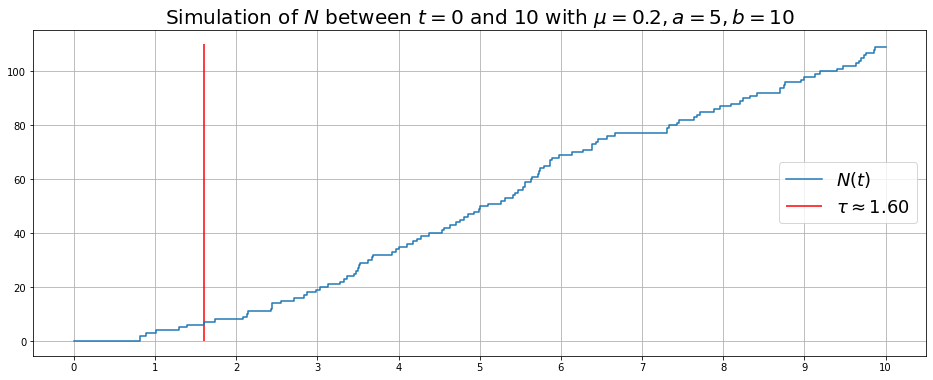

In [7]:
seed = 56
# 5 c'est très mauvais pour kmeans, 3 tau est loin, 4 tau est au tout début, 2 Z est pas ouf
rng = np.random.default_rng(seed)

mu = 0.2
a = 5
b = 10
end = 10

tau, Tas, Tbs = N(mu, a, b, end, rng)
plotN(tau, Tas, Tbs, end)
plt.title(rf"Simulation of $N$ between $t = 0$ and {end} with $\mu = {mu}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

$\textbf{Question 3}$

Pour calculer $\hat Z$, on utilise le résultat de la question 10 de l'exercice 2.2 du polycopié, *i.e.*
$$\hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t \left(h(s) - (b-a)\hat{Z}(s)\right)\left(1-\hat{Z}(s)\right)\mathrm{d}s$$

On remarque qu'en dehors des instants de sauts, $\hat Z$ est $\mathcal{C}^1$. On peut donc dériver l'équation ci-dessus pour obtenir l'équation différentielle ci-dessous que nous résoudrons numériquement entre chaque instant de saut :
$$\frac{\mathrm{d}}{\mathrm{d}t}\hat{Z}(t) = \left(\mu - (b-a)\hat{Z}(t)\right)\left(1-\hat{Z}(t)\right)$$

Quant à la valeur aux instants de sauts, elle est donnée par la formule
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a)\hat{Z}(T_n^-)\left(1-\hat{Z}(T_n^-)\right)}{a + (b-a)\hat{Z}(T_n^-)}$$

Pour approximer $\hat{Z}(T_n^-)$, on choisira simplement le dernier point de la simulation numérique qui précède le saut.

Dans la suite du code, `Z` désignera $\hat Z$.

In [19]:
def Z(mu, a, b, end, T, num = 50) :
    """Computes an approximation of the conditional expectation Z(t) for
    all t between 0 and T

    Parameters
    ----------
    mu : float
        The parameter of the exponential distribution of tau
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    end : float
        The end of the simulation
    T : list
        The arrival times of N
    num : int, optional
        The number of points used to approximate Z between any two arrival times
        (default is 50)

    Returns
    -------
    list
        The list of points used to plot Z (linspaces + arrival times)
    numpy array
        1D array of values of Z
    """

    dZ = lambda y, t : (mu - (b - a)*y)*(1 - y)
    z = [0]
    ts = []
    jumps = []
    for i in range(len(T) - 1):
        t = np.linspace(T[i], T[i+1], num)[:-1]
        ts += list(t)
        # Solve the differential equation between two points
        z = np.append(z, odeint(dZ, z[-1], t).flatten())
        zjump = (b-a)*z[-1]*(1 - z[-1])/(a + (b-a)*z[-1])
        # Add the jump
        z = np.append(z, zjump + z[-1])
        jumps.append(zjump + z[-1])
        ts.append(T[i+1])

    return ts, z[1:], jumps

In [9]:
def plotZ(ts, z, tau, end) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float
        The end of the simulation
    """
    
    plt.figure(figsize = (16,6))
    plt.plot(ts, z, label=r'$\hatZ (t) = \mathbb{E}\left[\mathbb{1}_{\tau \leq t}|\mathcal{F}^N_t\right]$')
    plt.xticks(range(end + 1))
    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    plt.legend(fontsize = 15)
    plt.grid()

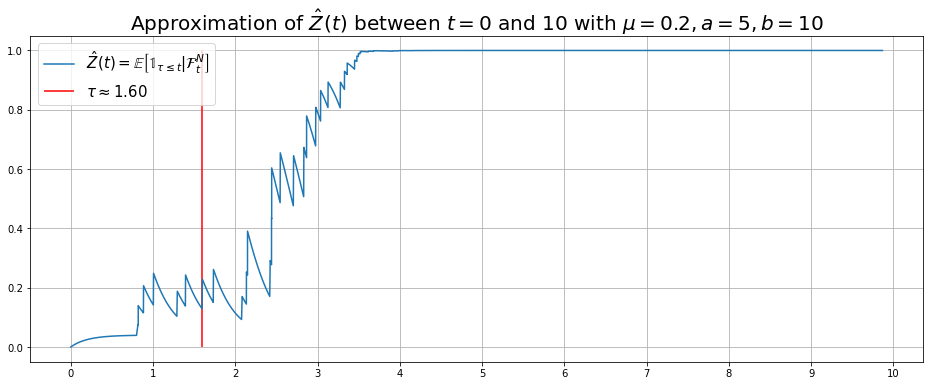

In [20]:
T = [0] + Tas + Tbs
ts, z, jumps = Z(mu, a, b, end, T)

plotZ(ts, z, tau, end)
plt.title(rf"Approximation of $\hatZ (t)$ between $t = 0$ and {end} with $\mu = {mu}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

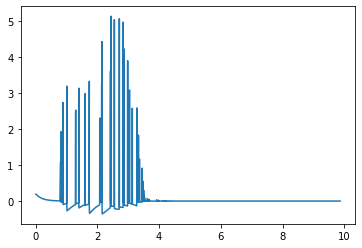

In [24]:
# Tests en dérivant Z

dt = ts[1] - ts[0]
dZ = np.gradient(z, dt)
plt.plot(ts, dZ)

0.8401536449633735

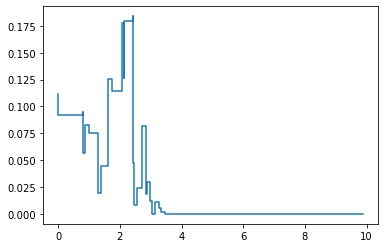

In [34]:
# tests en utilisant que ce qu'on connaît sur les sauts de z

djumps = []
for i in range(len(jumps) - 1):
    djumps.append(abs(jumps[i+1]-jumps[i]))
plt.step(T[:-1], djumps)
djumps = np.array(djumps)
apptau = np.argmax(djumps)
T[apptau] - tau

In [38]:
# Tests en smoothant la fonction avec une fonction random choppée sur stackoverflow
# ici : https://stackoverflow.com/questions/9876290/how-do-i-compute-derivative-using-numpy

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    

    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


C:\Users\aurc\AppData\Local\Temp/ipykernel_18412/4245011576.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
C:\Users\aurc\AppData\Local\Temp/ipykernel_18412/4245011576.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

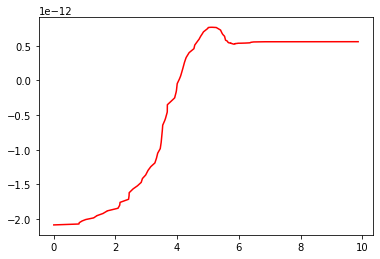

In [64]:
zsmooth = savitzky_golay(z, 5000, 5) # window size 51, polynomial order 3

plt.plot(ts,zsmooth, color='red')
plt.show()

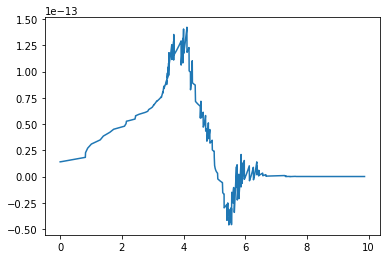

In [65]:
dzsmooth = np.gradient(zsmooth, dt)
plt.plot(ts, dzsmooth)

$\textbf{Question 4}$

On commence par une application naïve de l'algorithme.

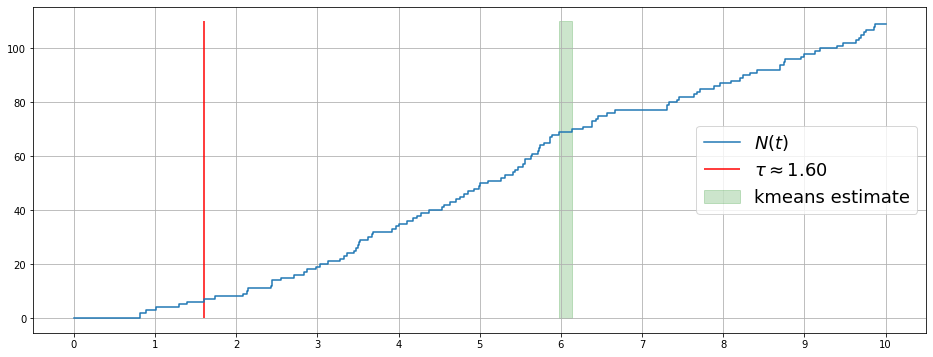

In [12]:
kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++').fit(np.array(T).reshape(-1, 1))
# , random_state=np.random.RandomState(seed)
pred = kmeans.predict(np.array(T).reshape(-1, 1))
p = abs((1-pred[0])-pred)

plotN(tau, Tas, Tbs, end, kmeans_estimate = (T[p.sum()-1], T[p.sum()]))

On change maintenant l'initialisation en utilisant la valeur de $\mu$.

In [13]:
m = np.array(T).mean()
def init(X, n_clusters, random_state):
    # We have only one feature :
    X = X.flatten() + m
    i = len([x for x in X if x < 1/mu])
    n = len(X)
    return [X[random_state.randint(i, n)]-m], [X[random_state.randint(0, i)]-m]

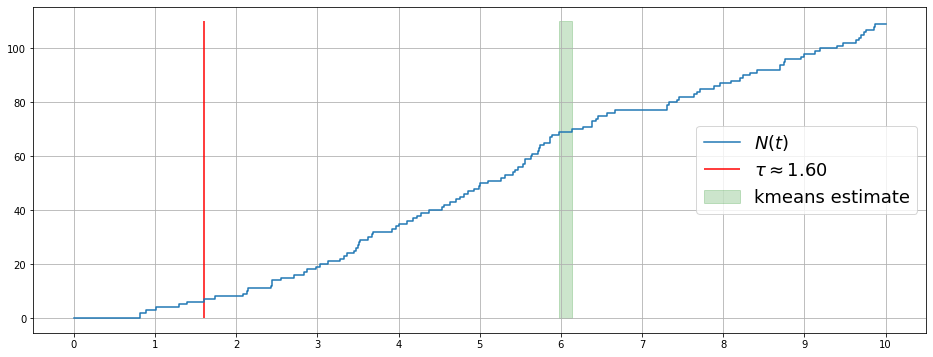

In [14]:
kmeans = KMeans(n_clusters=2, n_init=10, init=init).fit(np.array(T).reshape(-1, 1))
pred = kmeans.predict(np.array(T).reshape(-1, 1))
p = abs((1-pred[0])-pred)

plotN(tau, Tas, Tbs, end, kmeans_estimate = (T[p.sum()-1], T[p.sum()]))

$\textbf{Question 5}$
- Pour k means il choisit un des sauts qui lui apparaissent bons mais aléatoirement
- k means n'utilise pas les données d'entrée (a,b,$\mu$)
- Pour l'autre méthode, on peut regarder la stabilité qui suit et donc choisir le seul truc stable